In [38]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# models
#from keras.applications.vgg16 import VGG16
#from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import tensorflow as tf
import PIL as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from random import randint
import pandas as pd
import pickle

In [5]:
path = r"/Users/thorsten/code/ThorstenCodes/MorphoMind/raw_data/plate_24277/24277-Hoechst"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.tif'):
          # adds only the image files to the flowers list
            images.append(file.name)


In [6]:
print(images[:10])

['cdp2bioactives_c22_s1_w1a45f01c1-0dab-4928-9c2d-03066adaafff.tif', 'cdp2bioactives_f20_s4_w183414096-6540-4647-a575-d91a4965ea18.tif', 'cdp2bioactives_g09_s1_w1deb4c9ec-770e-4d91-8415-3247fe069eff.tif', 'cdp2bioactives_p13_s3_w109ea8f2b-bc2e-4ff0-9a47-1e8f0fda3a79.tif', 'cdp2bioactives_l07_s4_w15a5436ca-b412-4f0c-b899-e0b1ff1be13b.tif', 'cdp2bioactives_o23_s6_w1ab30a369-50ac-48ae-8067-4d152ada019e.tif', 'cdp2bioactives_l04_s6_w159827906-c3ee-4954-b72d-5e58d2c05355.tif', 'cdp2bioactives_j19_s3_w175217b1a-6e7a-4756-a242-2bae78ada812.tif', 'cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif', 'cdp2bioactives_i23_s5_w10cebd66b-1160-466d-a7f0-d977c6e1d146.tif']


In [34]:
# Open the image file
with Image.open("/Users/thorsten/code/ThorstenCodes/MorphoMind/raw_data/plate_24277/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif") as img:
    # Get color mode (e.g., 'RGB', 'RGBA', 'L' for grayscale, etc.)
    color_mode = img.mode
    img = img
    img_8bit = img.convert('L')

    # Print color mode
    print(f"Color mode: {color_mode}")

    # Determine if the image is grayscale
    is_grayscale = color_mode == 'L'

    # Print whether the image is grayscale
    print(f"Is grayscale: {is_grayscale}")

Color mode: I;16
Is grayscale: False


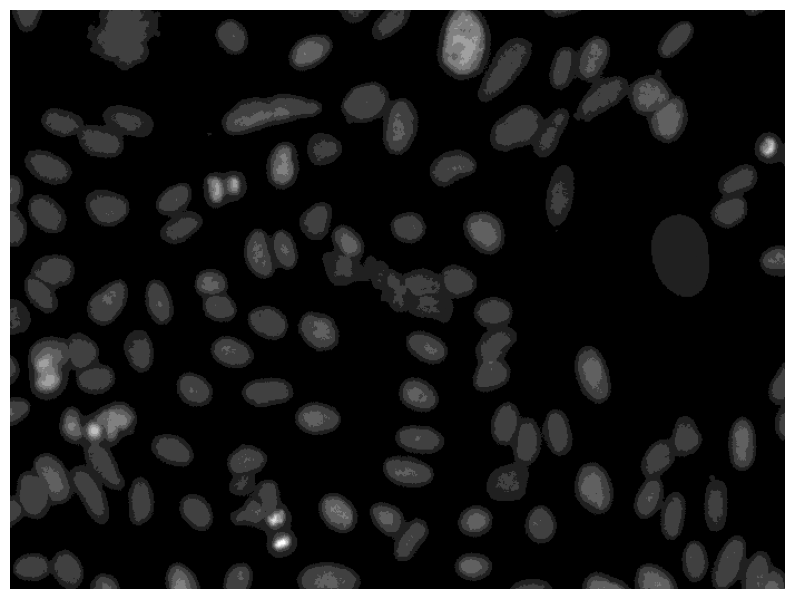

In [31]:
# Load the 16-bit TIFF image
path_to_16bit_tiff = '../raw_data/plate_24277/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif'
img = Image.open(path_to_16bit_tiff)

# Convert the PIL image to a NumPy array
img_array = np.array(img)

# Scale the image data to 8-bit range for visualization purposes
# This maps the data range [0, 65535] (for 16-bit) to [0, 255] (for 8-bit)
img_array_8bit = (img_array / 256).astype('uint8')

# Use Matplotlib to display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_array_8bit, cmap='gray') # Use cmap='gray' for grayscale images
plt.axis('off') # Optionally remove the axis
plt.show()

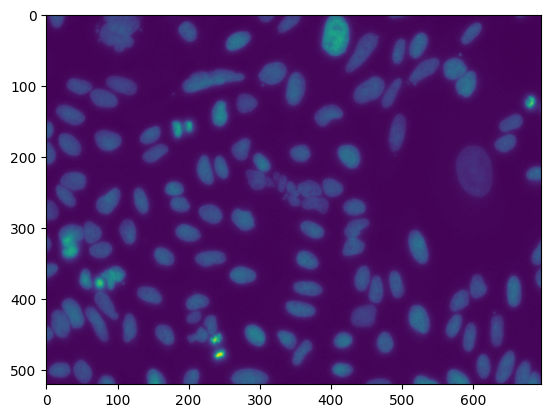

In [42]:
pil_im = Image.open('cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif')
imshow(np.asarray(pil_im))

In [52]:
img[2,2,:]

array([151, 151, 151], dtype=uint8)

(520, 696)
(520, 696)


/Users/thorsten/.pyenv/versions/3.10.6/envs/MorphoMind/lib/python3.10/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


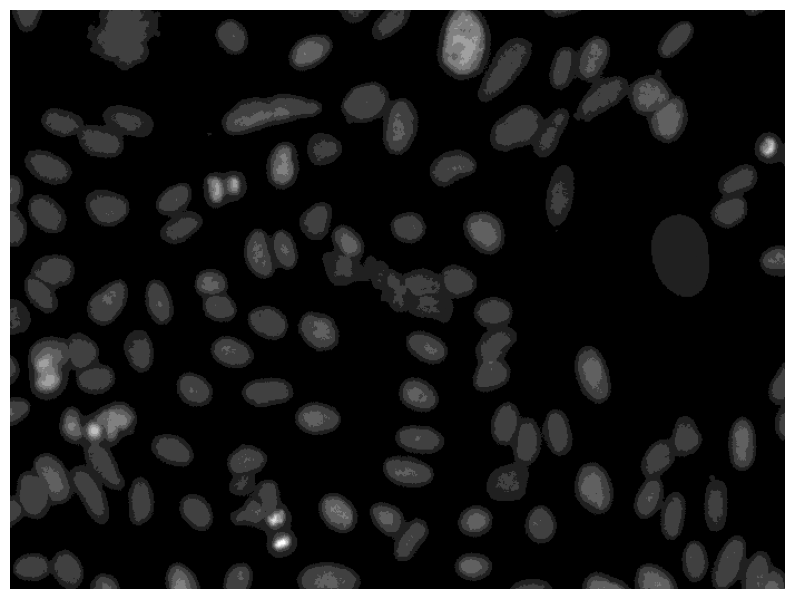

In [53]:
img = load_img(images[0], grayscale=True)
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

img_array_8bit = (img_array / 256).astype('uint8')

print(img_array_8bit.shape)

plt.figure(figsize=(10, 10))
plt.imshow(img_array_8bit, cmap='gray') # Use cmap='gray' for grayscale images
plt.axis('off') # Optionally remove the axis
plt.show()

In [57]:
tensor_image = tf.expand_dims(img, axis=2)
tensor_image.shape

TensorShape([520, 696, 1])

In [ ]:


def build_feature_extractor(img_width = 224, img_height = 224, pretrained_model='InceptionV3'):

    models = {'InceptionV3': keras.applications.InceptionV3(weights="imagenet", include_top=False, pooling="avg",input_shape=(img_height, img_width, 3)),
              'ResNet50V2': keras.applications.ResNet50V2(weights="imagenet", include_top=False, pooling="avg",input_shape=(img_height, img_width, 3)),
              'MobileNetV2': keras.applications.MobileNetV2(weights="imagenet", include_top=False, pooling="avg",input_shape=(img_height, img_width, 3)),
              'InceptionResNetV2': keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, pooling="avg",input_shape=(img_height, img_width, 3)),
              }

    preprocess = {'InceptionV3': keras.applications.inception_v3.preprocess_input,
                  'ResNet50V2': keras.applications.resnet_v2.preprocess_input,
                  'MobileNetV2': keras.applications.mobilenet_v2.preprocess_input,
                  'InceptionResNetV2': keras.applications.inception_resnet_v2.preprocess_input
                 }

    feature_extractor = models[pretrained_model]
    preprocess_input = preprocess[pretrained_model]

    inputs = keras.Input((img_height, img_width, 3))

    preprocessed = preprocess_input(inputs)
    outputs = feature_extractor(preprocessed)

    return keras.Model(inputs, outputs, name="feature_extractor")